In [41]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

import sys
sys.path.insert(0, r'..')

from Backtest import *
from Backtest.data import OHLCDataHandler
from MACD_BOLLStrategy import MACD_BOLLStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [42]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import hyperopt.pyll.stochastic

In [74]:
def run_backtest(config, trading_data, ohlc_data, short_window, delta_window, window, a):
    short_window = int(short_window)
    long_window = short_window + int(delta_window)
    window = int(window)
    config['title'] = "MACD_BOLLStrategy" + "_" +  str(short_window) + "_" + str(long_window) + "_" + str(window) + "_" + str(a)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = MACD_BOLLStrategy(config, events_queue, data_handler,
                            short_window=short_window, long_window=long_window,
                            window = window, a = a)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    
    # dict_ans = {
    #     "short_window": [short_window],
    #     "long_window": [long_window],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return -1 * (results['cum_returns'][-1] - 1)

In [75]:
def f(params):
    config = {
        "csv_dir": "../Binance",
        "out_dir": "../results/MACD_BOLLStrategy",
        "title": "MACD_BOLLStrategy",
        "is_plot": False,
        "save_plot": False,
        "save_tradelog": False,
        "start_date": pd.Timestamp("2018-02-01T00:0:00", freq = "30" + "T"),    # str(freq) + "T"
        "end_date": pd.Timestamp("2018-06-01T00:00:00", freq = "30" + "T"),
        "equity": 1.0,
        "freq": 30,      # min
        "commission_ratio": 0.001,
        "suggested_quantity": None,     # None or a value
        "max_quantity": None,           # None or a value, Maximum purchase quantity
        "min_quantity": None,           # None or a value, Minimum purchase quantity
        "min_handheld_cash": None,      # None or a value, Minimum handheld funds
        "exchange": "Binance",
        "tickers": ['BTCUSDT']
    }
    # trading_data = {}
    # for ticker in config['tickers']:
    #     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
    #     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

    ohlc_data = {}
    for ticker in config['tickers']:
        # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
        ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '_OHLC_30min.h5', key=ticker)

    trading_data = None
    
    short_window = params['short_window']
    delta_window = params['delta_window']
    window = params['window']
    a = params['a']
    val = run_backtest(config, trading_data, ohlc_data, short_window, delta_window, window, a)
    return {'loss': val, 'status': STATUS_OK}

In [76]:
space = {
    'short_window': hp.randint('short_window', 120),
    'delta_window': hp.randint('delta_window', 120),
    'window': hp.randint('window', 240),
    'a': hp.uniform('a', 0.1, 3)
}

In [77]:
# print(hyperopt.pyll.stochastic.sample(space))

In [78]:
trials = Trials()

In [79]:
best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

---------------------------------
MACD_BOLLStrategy_4_85_110_1.2372148709034494
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-06-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.0107585179
Sortino Ratio: 0.0171287927
Information Ratio: 0.2603750827
Max Drawdown: 0.1911805825
Max Drawdown Duration: 267300
Total Returns: -0.0393465104
Annualized Returns: -0.1196789691
Compound Annual Growth Rate: -0.1149375630
---------------------------------
Trades: 29
Trade Winning: 41.38%
Average Trade: 0.18%
Average Win: 4.08%
Average Loss: -2.57%
Best Trade: 11.40%
Worst Trade: -6.06%
Worst Trade Date: 35.0
Avg Days in Trade: 26.930555555555557
---------------------------------
---------------------------------
MACD_BOLLStrategy_64_127_121_0.14589429123071387
------------------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.0382778230
Sortino Ratio: 0.0363790246
Information Ratio: 0.2549719047
Max Drawdown: 0.2325989623
Max Drawdown Duration: 494000
Total Returns: -0.0261236357
Annualized Returns: -0.0794593919
Compound Annual Growth Rate: -0.0773595942
---------------------------------
Trades: 16
Trade Winning: 31.25%
Average Trade: 0.25%
Average Win: 6.19%
Average Loss: -2.46%
Best Trade: 17.35%
Worst Trade: -5.90%
Worst Trade Date: 5.0
Avg Days in Trade: 46.187222222222225
---------------------------------
---------------------------------
MACD_BOLLStrategy_2_121_51_0.15242052256459307
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-06-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 

Total Returns: -0.0652098964
Annualized Returns: -0.1983467682
Compound Annual Growth Rate: -0.1854418894
---------------------------------
Trades: 36
Trade Winning: 27.78%
Average Trade: 0.15%
Average Win: 6.56%
Average Loss: -2.31%
Best Trade: 16.80%
Worst Trade: -8.96%
Worst Trade Date: 45.0
Avg Days in Trade: 14.86111111111111
---------------------------------
---------------------------------
MACD_BOLLStrategy_87_164_102_2.675924706755988
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-06-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.3376170159
Sortino Ratio: 1.2619708500
Information Ratio: 0.8903773127
Max Drawdown: 0.1542113176
Max Drawdown Duration: 247600
Total Returns: 0.1644558911
Annualized Returns: 0.5002200021
Compound Annual Growth Rate: 0.589001304

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -8.1162702219
Sortino Ratio: -9.4575383763
Information Ratio: -4.8765884583
Max Drawdown: 0.7576515336
Max Drawdown Duration: 563200
Total Returns: -0.7566536228
Annualized Returns: -2.3014881028
Compound Annual Growth Rate: -0.9864137159
---------------------------------
Trades: 454
Trade Winning: 35.46%
Average Trade: -0.11%
Average Win: 0.86%
Average Loss: -0.63%
Best Trade: 12.15%
Worst Trade: -3.59%
Worst Trade Date: 3.0
Avg Days in Trade: 3.347777777777778
---------------------------------
---------------------------------
MACD_BOLLStrategy_87_162_81_1.1177727300152078
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-06-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Rat

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 0.9127538143
Sortino Ratio: 1.1700952548
Information Ratio: 0.7478884052
Max Drawdown: 0.1292944482
Max Drawdown Duration: 246100
Total Returns: 0.1068480570
Annualized Returns: 0.3249961734
Compound Annual Growth Rate: 0.3617614054
---------------------------------
Trades: 19
Trade Winning: 42.11%
Average Trade: 0.92%
Average Win: 5.83%
Average Loss: -2.65%
Best Trade: 19.88%
Worst Trade: -5.26%
Worst Trade Date: 6.0
Avg Days in Trade: 11.157777777777778
---------------------------------
---------------------------------
MACD_BOLLStrategy_101_155_55_2.322036257135639
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-06-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.5

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: -0.9804174425
Sortino Ratio: -1.8297599823
Information Ratio: -0.2779555574
Max Drawdown: 0.3051087159
Max Drawdown Duration: 483400
Total Returns: -0.1502252886
Annualized Returns: -0.4569352530
Compound Annual Growth Rate: -0.3905111948
---------------------------------
Trades: 114
Trade Winning: 31.58%
Average Trade: 0.08%
Average Win: 2.17%
Average Loss: -0.89%
Best Trade: 12.11%
Worst Trade: -2.88%
Worst Trade Date: 13.0
Avg Days in Trade: 15.736666666666666
---------------------------------
---------------------------------
MACD_BOLLStrategy_40_124_55_2.5267554032391035
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2018-02-01 00:00:00
	End Date	: 2018-06-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ra

In [80]:
best

{'a': 2.5267554032391035, 'delta_window': 84, 'short_window': 40, 'window': 55}

In [81]:
for trial in trials.trials:
    print(trial['misc']['vals'], "\t",trial['result']['loss'])

{'a': [1.2372148709034494], 'delta_window': [81], 'short_window': [4], 'window': [110]} 	 0.03934651039979986
{'a': [0.14589429123071387], 'delta_window': [63], 'short_window': [64], 'window': [121]} 	 0.014643413619478296
{'a': [1.9585573390121787], 'delta_window': [72], 'short_window': [71], 'window': [213]} 	 0.013791357591343534
{'a': [0.26746981315864315], 'delta_window': [59], 'short_window': [51], 'window': [163]} 	 -0.07016822266259015
{'a': [0.13535998927971532], 'delta_window': [77], 'short_window': [62], 'window': [128]} 	 -0.04107850068294905
{'a': [1.4729560700050002], 'delta_window': [59], 'short_window': [33], 'window': [59]} 	 0.058784113213992795
{'a': [2.1732704873475885], 'delta_window': [5], 'short_window': [78], 'window': [160]} 	 0.0897827897724327
{'a': [1.6736450635437525], 'delta_window': [61], 'short_window': [50], 'window': [186]} 	 0.22207079957936882
{'a': [2.34419074390109], 'delta_window': [14], 'short_window': [15], 'window': [50]} 	 0.22028524450485742


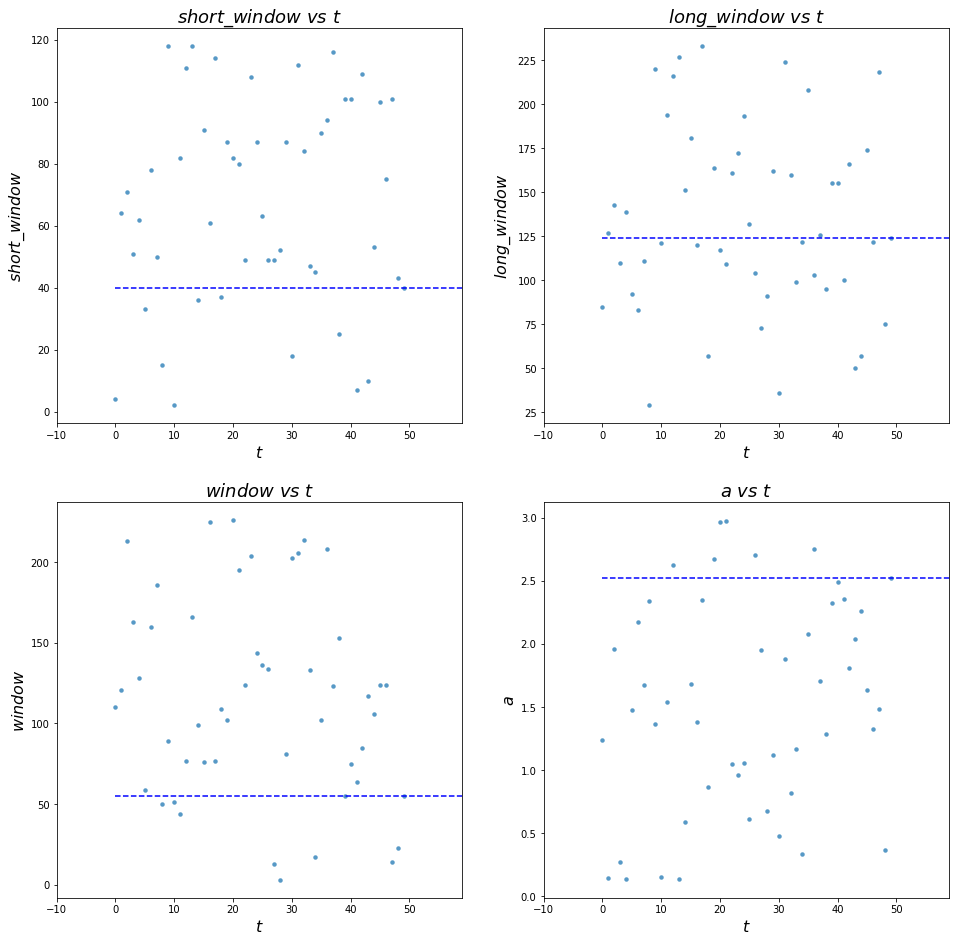

In [82]:
f, ax = plt.subplots(2, 2, figsize = (16, 16))
xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['short_window'] for t in trials.trials]
ax[0,0].set_xlim(xs[0]-10, xs[-1]+10)
ax[0,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,0].set_title('$short\_window$ $vs$ $t$ ', fontsize=18)
ax[0,0].set_xlabel('$t$', fontsize=16)
ax[0,0].set_ylabel('$short\_window$', fontsize=16)
ax[0,0].hlines(best['short_window'], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [[t['misc']['vals']['delta_window'][0]+ t['misc']['vals']['short_window'][0]] for t in trials.trials]
ax[0,1].set_xlim(xs[0]-10, xs[-1]+10)
ax[0,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,1].set_title('$long\_window$ $vs$ $t$ ', fontsize=18)
ax[0,1].set_xlabel('$t$', fontsize=16)
ax[0,1].set_ylabel('$long\_window$', fontsize=16)
ax[0,1].hlines(best['delta_window'] + best['short_window'], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['window'] for t in trials.trials]
ax[1,0].set_xlim(xs[0]-10, xs[-1]+10)
ax[1,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,0].set_title('$window$ $vs$ $t$ ', fontsize=18)
ax[1,0].set_xlabel('$t$', fontsize=16)
ax[1,0].set_ylabel('$window$', fontsize=16)
ax[1,0].hlines(best['window'], 0, 250,color='blue',linestyle="--")

xs = [t['tid'] for t in trials.trials]
ys = [t['misc']['vals']['a'] for t in trials.trials]
ax[1,1].set_xlim(xs[0]-10, xs[-1]+10)
ax[1,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,1].set_title('$a$ $vs$ $t$ ', fontsize=18)
ax[1,1].set_xlabel('$t$', fontsize=16)
ax[1,1].set_ylabel('$a$', fontsize=16)
ax[1,1].hlines(best['a'], 0, 250,color='blue',linestyle="--")

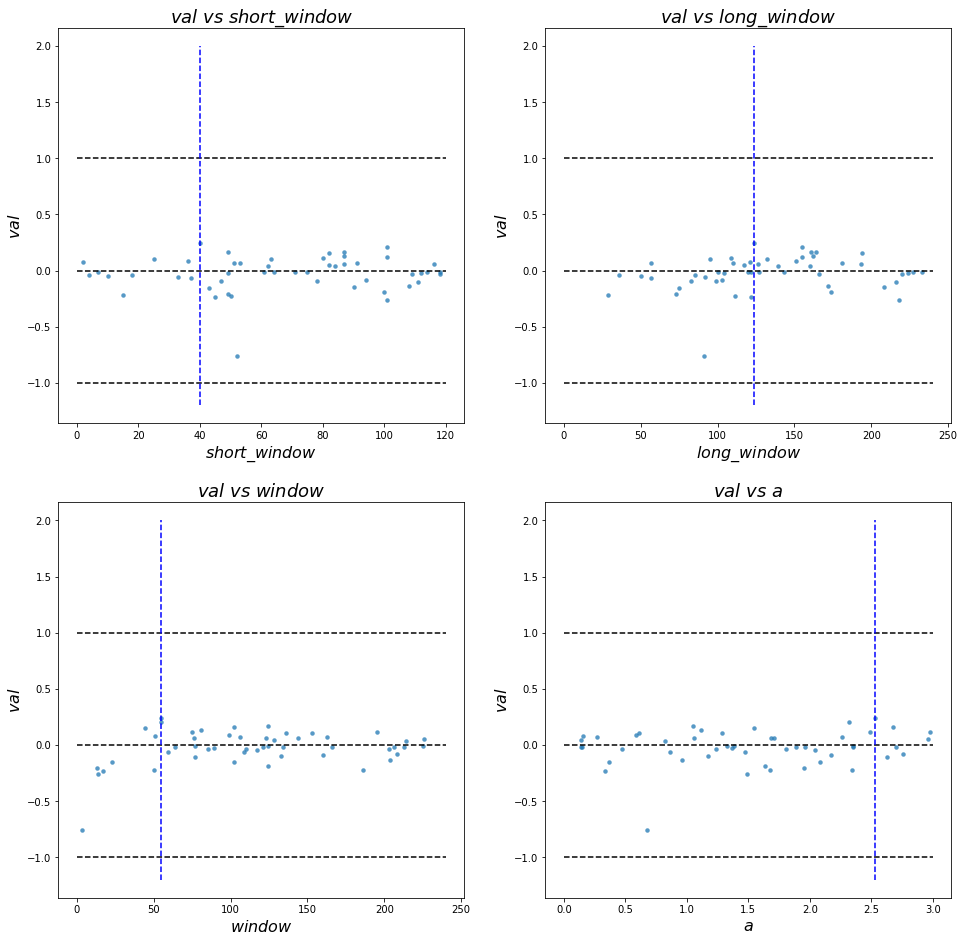

In [83]:
f, ax = plt.subplots(2,2, figsize = (16, 16))
xs = [t['misc']['vals']['short_window'] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[0,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,0].set_title('$val$ $vs$ $short\_window$ ', fontsize=18)
ax[0,0].set_xlabel('$short\_window$', fontsize=16)
ax[0,0].set_ylabel('$val$', fontsize=16)
ax[0,0].hlines(0, 0, 120, color='black',linestyle="--")
ax[0,0].hlines(-1, 0, 120, color='black',linestyle="--")
ax[0,0].hlines(1, 0, 120, color='black',linestyle="--")
ax[0,0].vlines(best['short_window'], -1.2, 2, color='blue',linestyle="--")

xs = [[t['misc']['vals']['delta_window'][0]+ t['misc']['vals']['short_window'][0]] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[0,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[0,1].set_title('$val$ $vs$ $long\_window$ ', fontsize=18)
ax[0,1].set_xlabel('$long\_window$', fontsize=16)
ax[0,1].set_ylabel('$val$', fontsize=16)
ax[0,1].hlines(0, 0, 240,color='black',linestyle="--")
ax[0,1].hlines(-1, 0, 240, color='black',linestyle="--")
ax[0,1].hlines(1, 0, 240,color='black',linestyle="--")
ax[0,1].vlines(best['delta_window'] + best['short_window'], -1.2, 2, color='blue',linestyle="--")

xs = [t['misc']['vals']['window'] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[1,0].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,0].set_title('$val$ $vs$ $window$ ', fontsize=18)
ax[1,0].set_xlabel('$window$', fontsize=16)
ax[1,0].set_ylabel('$val$', fontsize=16)
ax[1,0].hlines(0, 0, 240,color='black',linestyle="--")
ax[1,0].hlines(-1, 0, 240, color='black',linestyle="--")
ax[1,0].hlines(1, 0, 240,color='black',linestyle="--")
ax[1,0].vlines(best['window'], -1.2, 2, color='blue',linestyle="--")

xs = [t['misc']['vals']['a'] for t in trials.trials]
ys = [-1 * t['result']['loss'] for t in trials.trials]
ax[1,1].scatter(xs, ys, s=20, linewidth=0.01, alpha=0.75)
ax[1,1].set_title('$val$ $vs$ $a$ ', fontsize=18)
ax[1,1].set_xlabel('$a$', fontsize=16)
ax[1,1].set_ylabel('$val$', fontsize=16)
ax[1,1].hlines(0, 0, 3,color='black',linestyle="--")
ax[1,1].hlines(-1, 0, 3, color='black',linestyle="--")
ax[1,1].hlines(1, 0, 3,color='black',linestyle="--")
ax[1,1].vlines(best['a'], -1.2, 2, color='blue',linestyle="--")